# *Análisis No Supervisado del Dataset DermaMNIST*

⚠️ Importante: Como estas técnicas no supervisadas no usan etiquetas, trabajaremos solo con las imágenes preprocesadas.

# Objetivo

Añadir una sección de análisis no supervisado al proyecto que:

muestre agrupamientos naturales en las imágenes de piel,

reduzca la dimensionalidad para visualización,

compare K-Means y DBSCAN,

presente resultados visuales y métricas simples (silhouette, conteo de clusters, visualizaciones 2D).

In [11]:
# === Descargar automáticamente DermaMNIST ===
!wget https://zenodo.org/records/10519652/files/dermamnist.npz -O dermamnist.npz

--2025-11-24 16:43:45--  https://zenodo.org/records/10519652/files/dermamnist.npz
Resolving zenodo.org (zenodo.org)... 137.138.52.235, 188.185.48.75, 188.185.43.153, ...
Connecting to zenodo.org (zenodo.org)|137.138.52.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19725078 (19M) [application/octet-stream]
Saving to: ‘dermamnist.npz’

dermamnist.npz      100%[===================>]  18.81M  2.34MB/s    in 15s     

2025-11-24 16:44:01 (1.23 MB/s) - ‘dermamnist.npz’ saved [19725078/19725078]



In [13]:
# --- Carga del archivo .npz y asignación de variables ---
import numpy as np

# Asumimos que el archivo quedó en el directorio de trabajo como 'dermamnist.npz'
data = np.load('dermamnist.npz', allow_pickle=True)

# Asigno explícitamente las variables que usaré en el análisis no supervisado
x_train, y_train = data['train_images'], data['train_labels']
x_test, y_test = data['test_images'], data['test_labels']

# Comprobaciones rápidas
print('Formato de los arrays:')
print('  x_train:', x_train.shape)
print('  y_train:', y_train.shape)
print('  x_test :', x_test.shape)
print('  y_test :', y_test.shape)


Formato de los arrays:
  x_train: (7007, 28, 28, 3)
  y_train: (7007, 1)
  x_test : (2005, 28, 28, 3)
  y_test : (2005, 1)


In [15]:
# --- Imports y configuración general (visual y utilidades) ---
import matplotlib.pyplot as plt
import random
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.manifold import TSNE
import numpy as np

# Ajustes de visualización
plt.rcParams['figure.figsize'] = (8,5)


In [16]:
# --- Normalizo pixeles y aplanado para algoritmos clásicos ---
# Normalizo (si no está normalizado)
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32')  / 255.0

# Información de forma
n_samples = x_train.shape[0]
img_shape = x_train.shape[1:]   # por ejemplo (28,28,3)
print('Tamaño de imagen por muestra:', img_shape)

# Aplano imágenes: (N, H, W, C) -> (N, H*W*C)
x_train_flat = x_train.reshape(n_samples, -1)
print('Aplanado x_train:', x_train_flat.shape)

# Escalo características (recomendado para distancias)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_flat)

# Guardo el scaler para reproducibilidad
joblib.dump(scaler, 'scaler_dermamnist.joblib')
print('Scaler guardado en scaler_dermamnist.joblib')


Tamaño de imagen por muestra: (28, 28, 3)
Aplanado x_train: (7007, 2352)
Scaler guardado en scaler_dermamnist.joblib


In [17]:
# --- PCA para reducir dimensionalidad reteniendo 95% de la varianza ---
pca = PCA(n_components=0.95, svd_solver='full', random_state=42)
x_pca = pca.fit_transform(x_train_scaled)
print('Dimensiones después de PCA (95% varianza):', x_pca.shape)
# Guardar modelo PCA
joblib.dump(pca, 'pca_dermamnist.joblib')
print('PCA guardado en pca_dermamnist.joblib')


Dimensiones después de PCA (95% varianza): (7007, 36)
PCA guardado en pca_dermamnist.joblib


Número total de componentes retenidos por PCA: 36
Varianza acumulada final: 0.9501


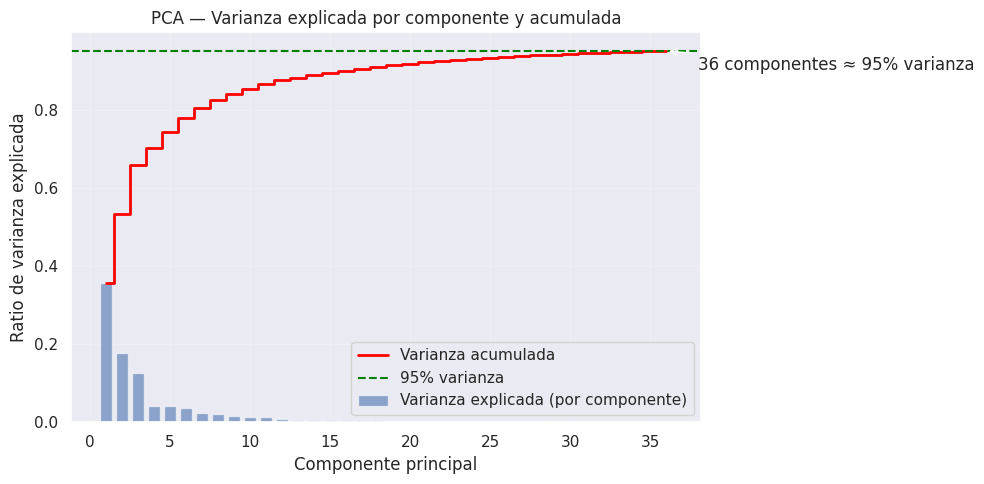

PCA alcanza 95% de varianza con aproximadamente 36 componentes.


In [41]:
# === Gráfica: Explained Variance Ratio (PCA) ===
# Aquí muestro cuántos componentes retuvo PCA para llegar al 95% de varianza.
# Además grafico la varianza explicada por componente y la varianza acumulada.

import matplotlib.pyplot as plt
import numpy as np
import joblib

# Si el objeto pca no existe, lo cargo (por seguridad)
try:
    pca
except NameError:
    pca = joblib.load('pca_dermamnist.joblib')
    print("Cargado PCA desde archivo.")

# Obtengo la varianza explicada
evr = pca.explained_variance_ratio_
cum_evr = np.cumsum(evr)
n_components = len(evr)

print(f"Número total de componentes retenidos por PCA: {n_components}")
print(f"Varianza acumulada final: {cum_evr[-1]:.4f}")

# Busco cuántos componentes necesito para alcanzar el 95%
k95 = int(np.searchsorted(cum_evr, 0.95)) + 1

# Gráfica
plt.figure(figsize=(10,5))

# Barras: varianza explicada por componente
plt.bar(range(1, n_components+1), evr, alpha=0.6, label='Varianza explicada (por componente)')

# Línea roja: varianza acumulada
plt.step(range(1, n_components+1), cum_evr, where='mid', color='red', linewidth=2,
         label='Varianza acumulada')

# Línea horizontal para marcar 95%
plt.axhline(0.95, color='green', linestyle='--', label='95% varianza')

plt.title('PCA — Varianza explicada por componente y acumulada')
plt.xlabel('Componente principal')
plt.ylabel('Ratio de varianza explicada')
plt.legend(loc='best')
plt.grid(alpha=0.2)

# Anoto el punto donde alcanza el 95%
plt.annotate(f'{k95} componentes ≈ 95% varianza',
             xy=(k95, cum_evr[k95-1]),
             xytext=(k95 + 2, cum_evr[k95-1] - 0.05),
             arrowprops=dict(arrowstyle='->'))

plt.tight_layout()
plt.show()

print(f"PCA alcanza 95% de varianza con aproximadamente {k95} componentes.")


Calculando distorsión e inercia para el elbow...
k = 1   distortion = 44.7876   inertia = 15658519.00
k = 2   distortion = 39.6215   inertia = 12050658.00
k = 3   distortion = 36.3168   inertia = 10400389.00
k = 4   distortion = 34.4359   inertia = 9346877.00
k = 5   distortion = 33.1525   inertia = 8571606.00
k = 6   distortion = 32.1392   inertia = 8089309.50
k = 7   distortion = 31.3946   inertia = 7716071.50
k = 8   distortion = 30.9127   inertia = 7466568.50
k = 9   distortion = 30.4479   inertia = 7247063.00
k = 10   distortion = 30.1174   inertia = 7083535.50
k = 11   distortion = 29.8329   inertia = 6928566.00
k = 12   distortion = 29.5166   inertia = 6792875.50


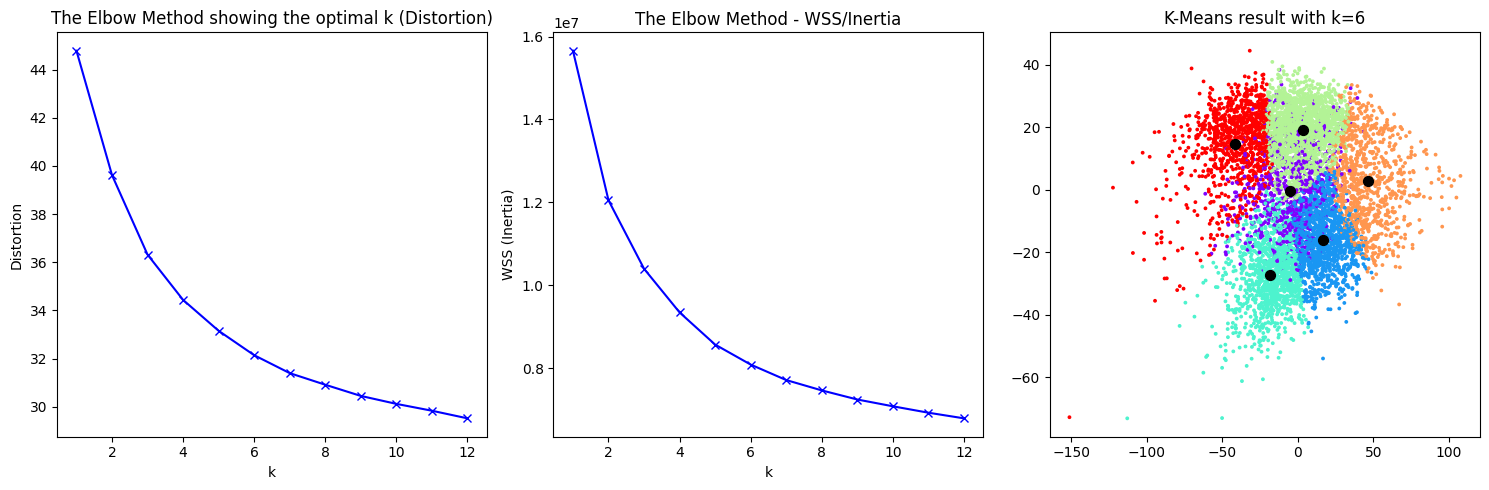

In [28]:
# === ELBOW APPROACH COMPLETO PARA MI DATASET (x_pca) ===

from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Rango de K (lo puedes ajustar si quieres más resolución)
K = range(1, 13)

distortions = []   # Distancia promedio al centro más cercano
wss = []           # Within-Cluster Sum of Squares (inercia)

print("Calculando distorsión e inercia para el elbow...")

for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_tmp = kmeanModel.fit_predict(x_pca)

    # Distortion: distancia promedio a centroides
    distortions.append(
        np.sum(
            np.min(cdist(x_pca, kmeanModel.cluster_centers_, 'euclidean'), axis=1)
        ) / x_pca.shape[0]
    )

    # WSS: inertia del modelo (la propia función de sklearn)
    wss.append(kmeanModel.inertia_)

    print(f"k = {k}   distortion = {distortions[-1]:.4f}   inertia = {wss[-1]:.2f}")

# --- Graficar los 3 plots estilo ejemplo ---

plt.figure(figsize=(15,5))

# plot 1 – Distortion (método del codo)
plt.subplot(131)
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k (Distortion)')

# plot 2 – Inercia (WSS)
plt.subplot(132)
plt.plot(K, wss, 'bx-')
plt.xlabel('k')
plt.ylabel('WSS (Inertia)')
plt.title('The Elbow Method - WSS/Inertia')

# plot 3 – Visualización del clustering para un K elegido
# Aquí elijo el K que tu prefieras. Para visualización pongo k=6 como ejemplo.
k_to_plot = 6  # cámbialo si quieres (puede ser 3, 5, 7, etc.)

kmeanModel_final = KMeans(n_clusters=k_to_plot, random_state=42, n_init=10).fit(x_pca)
labels_final = kmeanModel_final.labels_

# Para scatter usamos PCA(2) exclusivamente para visualización:
from sklearn.decomposition import PCA
pca2 = PCA(n_components=2)
coords2d = pca2.fit_transform(x_pca)

plt.subplot(133)
plt.scatter(coords2d[:,0], coords2d[:,1], c=labels_final, cmap='rainbow', s=3)
plt.scatter(kmeanModel_final.cluster_centers_[:,0], kmeanModel_final.cluster_centers_[:,1],
            color='black', s=50)
plt.title(f'K-Means result with k={k_to_plot}')

plt.tight_layout()
plt.show()


In [29]:
# --- Selección final de K y entrenamiento definitivo ---
# Voy a elegir k basándome en el resultado del Elbow + silhouette.
# Si quiero forzar manualmente puedo cambiar k_final.

import numpy as np
import joblib
from sklearn.cluster import KMeans

# Si calculaste sil_scores antes: uso el k que maximiza silhouette
try:
    # valid_idxs protege contra NaN
    valid_idxs = [i for i, s in enumerate(sil_scores) if not np.isnan(s)]
    if len(valid_idxs) > 0:
        best_idx = valid_idxs[int(np.nanargmax([sil_scores[i] for i in valid_idxs]))]
        k_suggest = list(K_range)[best_idx]
    else:
        k_suggest = None
except NameError:
    k_suggest = None

# Si prefiero forzar un valor (ej. 7) lo pongo aquí:
k_final = k_suggest if k_suggest is not None else 7
print(f"k sugerido por silhouette: {k_suggest} -> voy a usar k_final = {k_final}")

# Entreno el modelo final con k_final
kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=20)
labels_kmeans = kmeans_final.fit_predict(x_pca)

# Guardo el modelo y etiquetas para no re-entrenar
joblib.dump(kmeans_final, "kmeans_dermamnist_final.joblib")
np.save("clusters_kmeans_final.npy", labels_kmeans)
print("K-Means final entrenado y guardado: kmeans_dermamnist_final.joblib, clusters_kmeans_final.npy")


k sugerido por silhouette: 2 -> voy a usar k_final = 2
K-Means final entrenado y guardado: kmeans_dermamnist_final.joblib, clusters_kmeans_final.npy


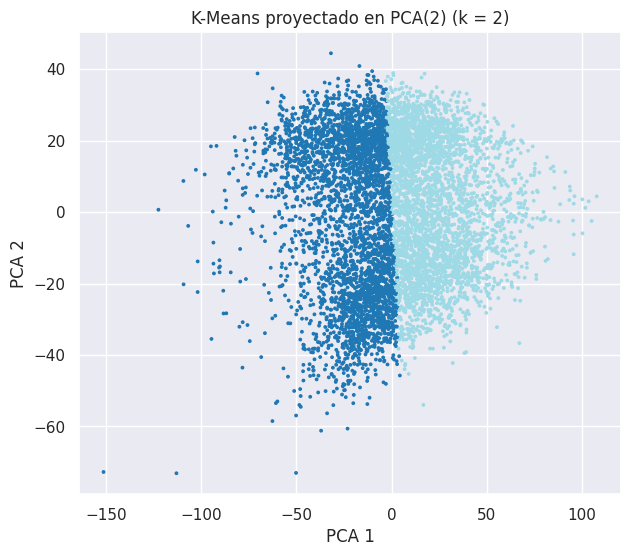

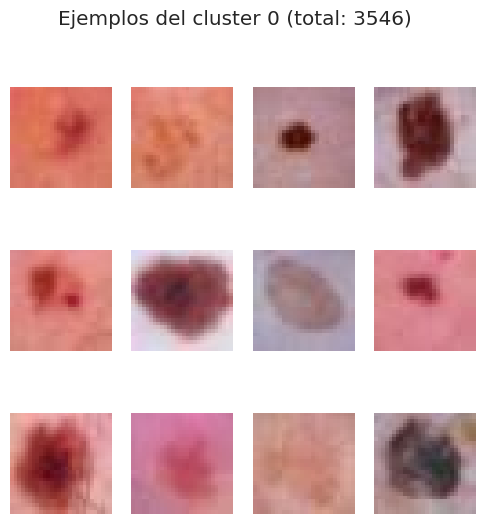

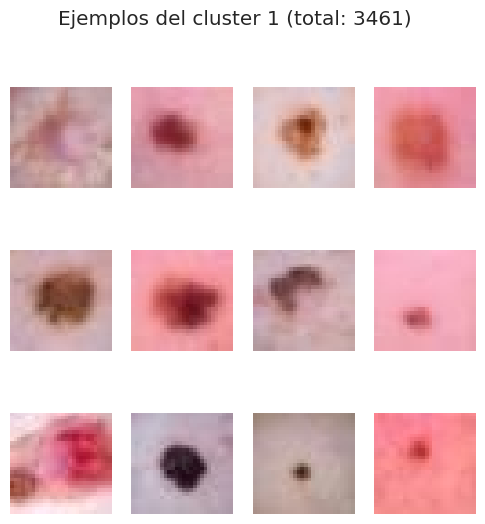

In [31]:
# --- Visualización del clustering usando PCA(2) ---
# Aquí proyecto el espacio de PCA original a 2 dimensiones solo con fines visuales.
# Esto no afecta al modelo, simplemente me permite ver cómo quedaron agrupados los puntos.

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca2 = PCA(n_components=2, random_state=42)
coords2d = pca2.fit_transform(x_pca)

plt.figure(figsize=(7,6))
plt.scatter(coords2d[:,0], coords2d[:,1], c=labels_kmeans, s=3, cmap='tab20')
plt.title(f"K-Means proyectado en PCA(2) (k = {k_final})")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


# --- Función para mostrar imágenes de un cluster ---
# Esta función me permite ver qué tipo de lesiones están quedando dentro de cada cluster.
def mostrar(cluster_id, n=12):
    idx = np.where(labels_kmeans == cluster_id)[0]
    if len(idx) == 0:
        print(f"Cluster {cluster_id} vacío.")
        return

    # Limito a n imágenes para que no se llene la pantalla
    idx = idx[:n]

    plt.figure(figsize=(6,6))
    for i, j in enumerate(idx):
        plt.subplot(3,4,i+1)
        plt.imshow(x_train[j])
        plt.axis("off")
    plt.suptitle(f"Ejemplos del cluster {cluster_id} (total: {len(np.where(labels_kmeans == cluster_id)[0])})")
    plt.show()


# --- Muestro ejemplos de los primeros clusters ---
# Si tengo pocos clusters, los muestro todos. Si tengo muchos, muestro solo los primeros.
num_clusters_to_show = min(k_final, 6)
for c in range(num_clusters_to_show):
    mostrar(c)


In [33]:
# === DBSCAN: preparación y explicación breve (mi voz) ===
# DBSCAN es un algoritmo basado en densidad: agrupa puntos que están
# juntos dentro de un radio eps y con al menos min_samples vecinos.
# Aquí preparo los datos para ejecutar DBSCAN y visualizar resultados
# al estilo del ejemplo (scatter original / labels DBSCAN / labels KMeans).

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

# Para visualizar uso coords2d (PCA2) que ya calculé antes para K-Means.
# Si no tienes coords2d en memoria, lo genero desde x_pca como en el pipeline.
try:
    coords2d  # si existe, lo uso
except NameError:
    from sklearn.decomposition import PCA
    pca_vis = PCA(n_components=2, random_state=42)
    coords2d = pca_vis.fit_transform(x_pca)

# Escalo coords2d para que eps tenga sentido en escala ~1
coords2d_scaled = StandardScaler().fit_transform(coords2d)

print("Datos para DBSCAN / KMeans listos. Forma:", coords2d_scaled.shape)


Datos para DBSCAN / KMeans listos. Forma: (7007, 2)


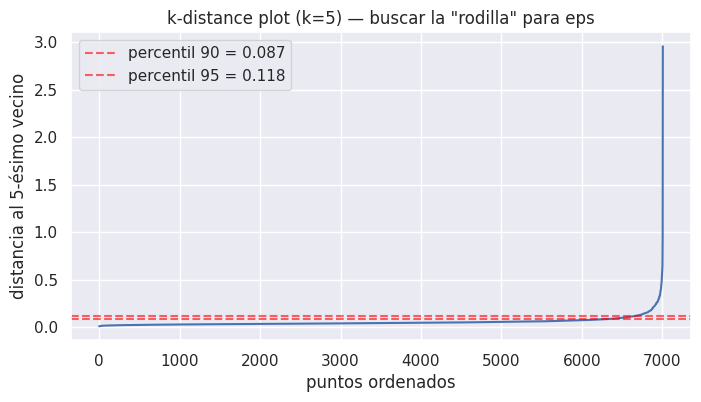

Percentiles (50,90,95): [0.04436918 0.0867413  0.11801131]


In [42]:
# k-distance plot para estimar eps
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# Elijo k = min_samples candidato (aquí 5 por defecto)
k_for_kdist = 5
nbrs = NearestNeighbors(n_neighbors=k_for_kdist).fit(coords2d_scaled)
distances, _ = nbrs.kneighbors(coords2d_scaled)
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(8,4))
plt.plot(k_distances)
plt.title(f'k-distance plot (k={k_for_kdist}) — buscar la "rodilla" para eps')
plt.xlabel('puntos ordenados')
plt.ylabel(f'distancia al {k_for_kdist}-ésimo vecino')
# marco algunos percentiles útiles
for p in [90,95]:
    val = np.percentile(k_distances, p)
    plt.axhline(val, color='red', linestyle='--', alpha=0.6, label=f'percentil {p} = {val:.3f}')
plt.legend(loc='best')
plt.show()

print("Percentiles (50,90,95):", np.percentile(k_distances, [50,90,95]))


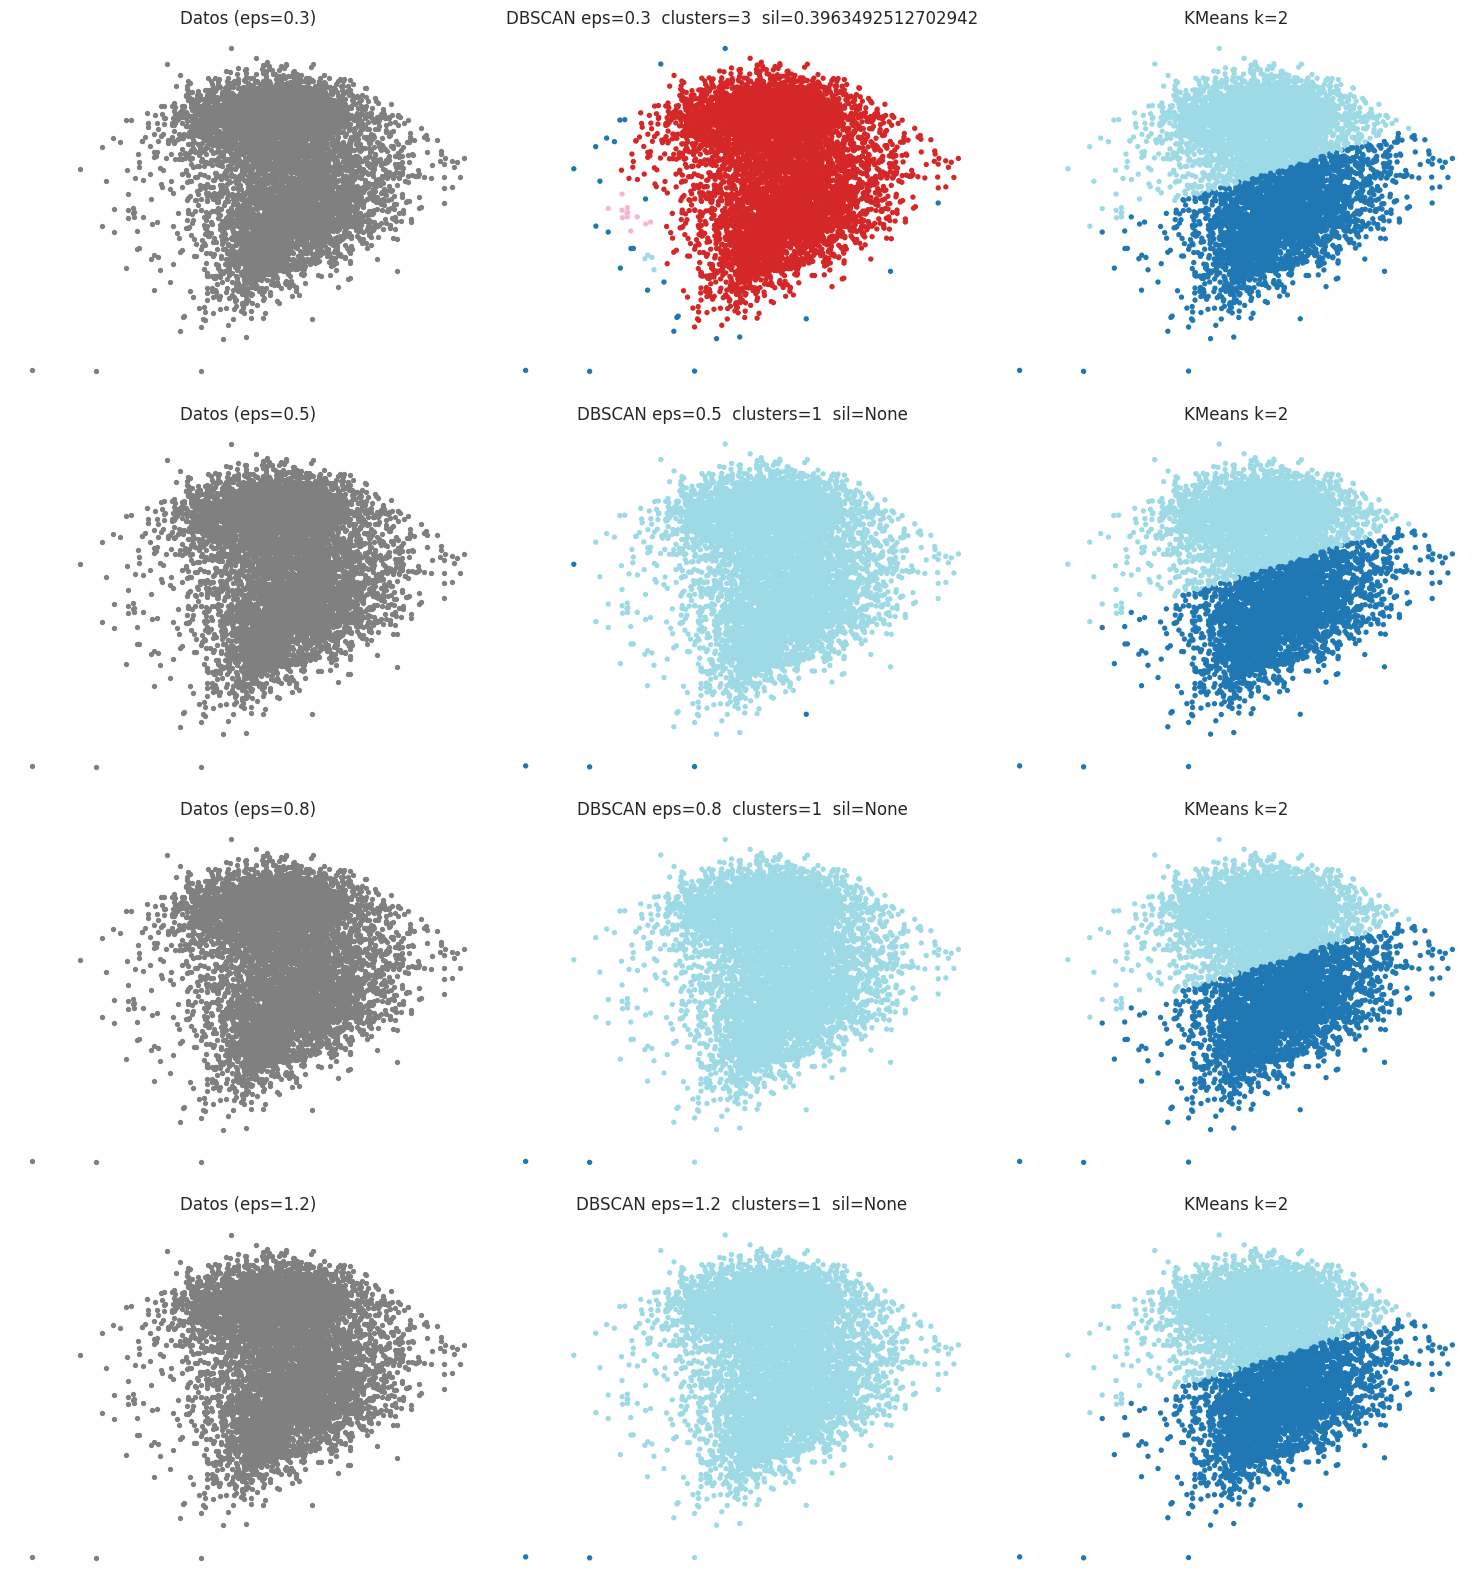

In [35]:
# Ejecutar DBSCAN con algunos eps y comparar con K-Means
from sklearn.metrics import silhouette_score

# Lista de eps a probar (en escala ya estandarizada, ajustar según k-distance)
eps_candidates = [0.3, 0.5, 0.8, 1.2]   # ajusta si tu k-distance sugirió valores distintos
min_samples = 5

# KMeans de comparación (fijo con k_final del pipeline, si existe)
k_to_compare = k_final if 'k_final' in globals() else 7
kmeans_comp = KMeans(n_clusters=k_to_compare, random_state=42, n_init=10).fit(coords2d_scaled)

plt.figure(figsize=(15, 4 * len(eps_candidates)))

for i, eps in enumerate(eps_candidates):
    db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
    labels_db = db.fit_predict(coords2d_scaled)
    clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)

    # silhouette: solo si hay al menos 2 clusters válidos (excluyendo ruido)
    sil = None
    try:
        if clusters > 1:
            sil = silhouette_score(coords2d_scaled, labels_db)
    except Exception:
        sil = None

    # plot original coords (left), DBSCAN labels (middle), KMeans (right) - adaptamos por eps
    plt.subplot(len(eps_candidates), 3, 3*i + 1)
    plt.scatter(coords2d_scaled[:,0], coords2d_scaled[:,1], c='gray', s=8)
    plt.title(f'Datos (eps={eps})')
    plt.axis('off')

    plt.subplot(len(eps_candidates), 3, 3*i + 2)
    plt.scatter(coords2d_scaled[:,0], coords2d_scaled[:,1], c=labels_db, s=8, cmap='tab20')
    plt.title(f'DBSCAN eps={eps}  clusters={clusters}  sil={sil}')
    plt.axis('off')

    plt.subplot(len(eps_candidates), 3, 3*i + 3)
    plt.scatter(coords2d_scaled[:,0], coords2d_scaled[:,1], c=kmeans_comp.labels_, s=8, cmap='tab20')
    plt.title(f'KMeans k={k_to_compare}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [36]:
# === Elijo una configuración de DBSCAN según observación y guardo etiquetas ===
# Aquí elijo manualmente la mejor eps tras inspeccionar los plots anteriores.

# Ejemplo: si el k-distance y los plots sugirieron eps=0.8:
eps_elegido = 0.8
min_samples_elegido = 5

db_final = DBSCAN(eps=eps_elegido, min_samples=min_samples_elegido, n_jobs=-1)
labels_db_final = db_final.fit_predict(coords2d_scaled)

# Informo y guardo
clusters_found = len(set(labels_db_final)) - (1 if -1 in labels_db_final else 0)
noise_count = int(np.sum(labels_db_final == -1))
print("DBSCAN final -> eps:", eps_elegido, "min_samples:", min_samples_elegido)
print("Clusters encontrados:", clusters_found, "Puntos etiquetados como ruido:", noise_count)

# Guardar etiquetas (en el orden de coords2d -> corresponde a las muestras originales)
np.save('clusters_dbscan_coords2d.npy', labels_db_final)
import joblib
joblib.dump(db_final, 'dbscan_coords2d.joblib')
print("DBSCAN guardado: dbscan_coords2d.joblib, clusters_dbscan_coords2d.npy")


DBSCAN final -> eps: 0.8 min_samples: 5
Clusters encontrados: 1 Puntos etiquetados como ruido: 2
DBSCAN guardado: dbscan_coords2d.joblib, clusters_dbscan_coords2d.npy


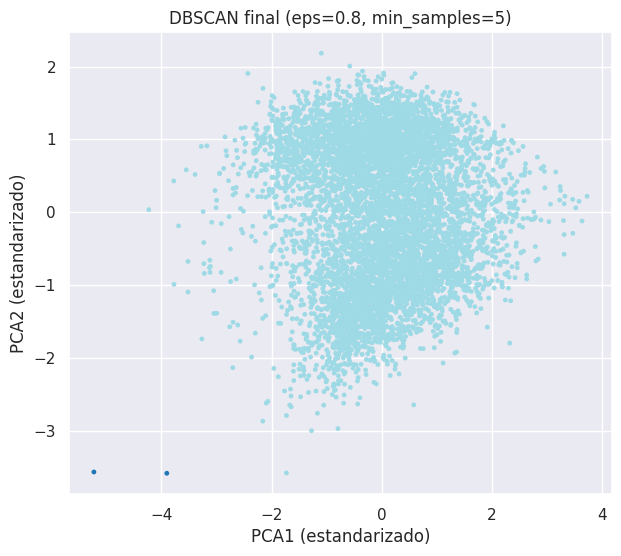

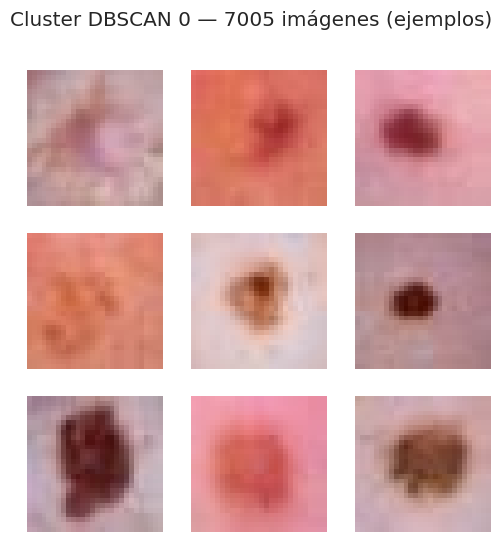

In [37]:
# === Visualización final y ejemplos de imágenes por cluster DBSCAN ===
import numpy as np
import matplotlib.pyplot as plt

# Scatter final
plt.figure(figsize=(7,6))
plt.scatter(coords2d_scaled[:,0], coords2d_scaled[:,1], c=labels_db_final, s=6, cmap='tab20')
plt.title(f'DBSCAN final (eps={eps_elegido}, min_samples={min_samples_elegido})')
plt.xlabel('PCA1 (estandarizado)')
plt.ylabel('PCA2 (estandarizado)')
plt.show()

# Muestro ejemplos por cada cluster no-ruido (hasta 6 clusters)
clusters_validos = [c for c in sorted(set(labels_db_final)) if c != -1]
if len(clusters_validos) == 0:
    print("DBSCAN no encontró clusters no-ruido con la configuración elegida.")
else:
    def mostrar_dbscan(cluster_id, n=9):
        idx = np.where(labels_db_final == cluster_id)[0]
        if len(idx) == 0:
            print(f"Cluster {cluster_id} vacío.")
            return
        sel = idx[:n]  # primeros n
        plt.figure(figsize=(6,6))
        for i,j in enumerate(sel):
            plt.subplot(3,3,i+1)
            # coords2d corresponde en orden a x_train; uso el índice j para mostrar la imagen original
            plt.imshow(x_train[j])
            plt.axis('off')
        plt.suptitle(f'Cluster DBSCAN {cluster_id} — {len(idx)} imágenes (ejemplos)')
        plt.show()

    for c in clusters_validos[:6]:
        mostrar_dbscan(c, n=9)


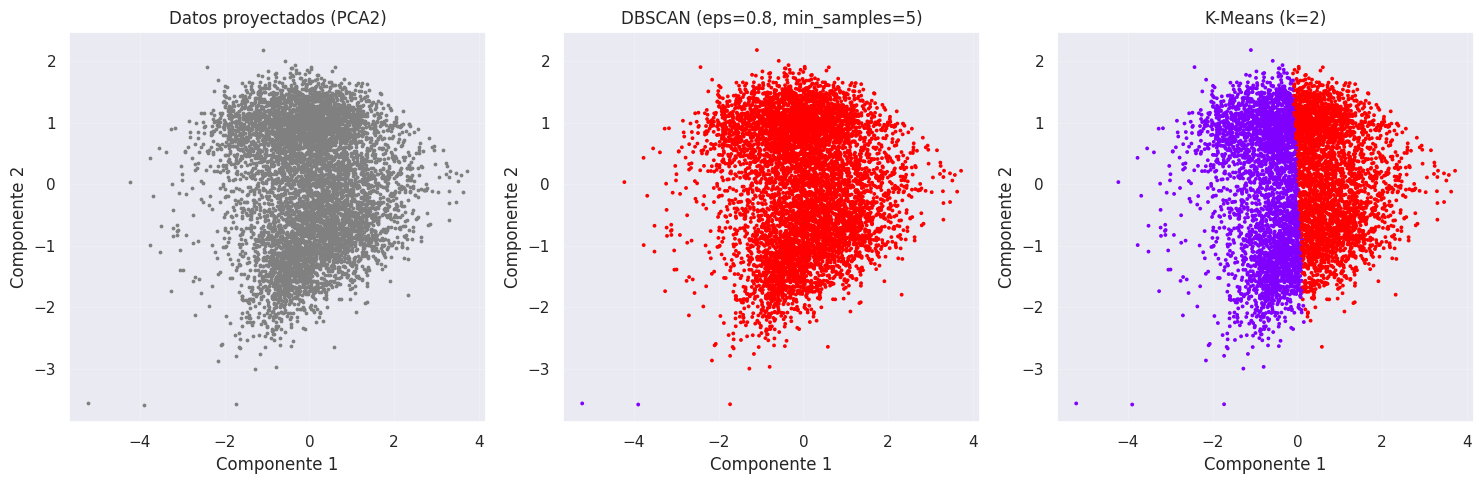

In [40]:
# === Comparación visual: K-Means vs DBSCAN (estilo exacto del ejemplo) ===
# Aquí replico el estilo del código de demostración: tres subplots,
# primero datos originales, luego DBSCAN, luego K-Means, usando mi dataset real.
# Trabajo sobre coords2d_scaled (PCA2 + escalado), que es un espacio visual interpretable.

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

# Aseguro que tengo coords2d_scaled listo
try:
    coords2d_scaled
except NameError:
    raise RuntimeError("coords2d_scaled no está definido. Debes ejecutar PCA(2) + escalado antes.")

# Aseguro que tengo DBSCAN y KMeans ya calculados
try:
    labels_db_final
except NameError:
    raise RuntimeError("labels_db_final no está definido. Debes ejecutar DBSCAN antes.")

try:
    labels_kmeans
except NameError:
    raise RuntimeError("labels_kmeans no está definido. Debes ejecutar K-Means antes.")

plt.figure(figsize=(15, 5))

# --- Subplot 1: Datos sin etiquetar ---
plt.subplot(131)
plt.scatter(coords2d_scaled[:,0], coords2d_scaled[:,1], c="gray", s=3)
plt.title("Datos proyectados (PCA2)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.grid(alpha=0.2)

# --- Subplot 2: DBSCAN ---
plt.subplot(132)
plt.scatter(coords2d_scaled[:,0], coords2d_scaled[:,1], c=labels_db_final, cmap='rainbow', s=3)
plt.title(f"DBSCAN (eps={eps_elegido}, min_samples={min_samples_elegido})")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.grid(alpha=0.2)

# --- Subplot 3: K-Means ---
plt.subplot(133)
plt.scatter(coords2d_scaled[:,0], coords2d_scaled[:,1], c=labels_kmeans, cmap='rainbow', s=3)
plt.title(f"K-Means (k={k_final})")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.grid(alpha=0.2)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


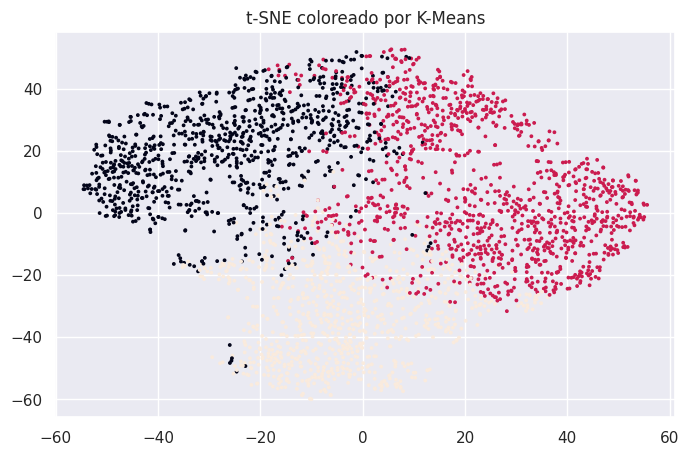

In [39]:
n_tsne = 3000
idx = np.random.choice(range(n_samples), size=n_tsne, replace=False)

x_sample = x_train_flat[idx]
x_sample_scaled = scaler.transform(x_sample)

pca_tsne = PCA(n_components=50)
x_sample_pca = pca_tsne.fit_transform(x_sample_scaled)

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000)
x_tsne = tsne.fit_transform(x_sample_pca)

labels_sample = kmeans.predict(pca.transform(x_sample_scaled))

plt.scatter(x_tsne[:,0], x_tsne[:,1], c=labels_sample, s=3)
plt.title("t-SNE coloreado por K-Means")
plt.show()
